# Lecture 18 - Machine Learning for Data Analysis
## Feature Preprocessing; K-Means Clustering

#### Announcements:
* 

#### Goals:
* Understand the purpose and mechanism of some basic feature preprocessing techniques:
  * Standardization and scaling for numerical features
  * Ordinal and one-hot encoding for categorical features
* Know the definition and purpose of the Hamming distance
* Understand the mechanism and implementation of k-means clustering algorithm.

In [211]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [212]:
numerical_features = [
    'bill_length_mm',
    'bill_depth_mm',
    'flipper_length_mm',
    'body_mass_g'
]

In [213]:
penguins = sns.load_dataset("penguins").dropna()

Last time we saw the $L^p$ family of distances:

$$d_p(a, b) = \sqrt[p]{\sum_{i=1}^d |a_i - b_i|^p}$$

and implemented this in Python:

In [ ]:
def L(p, a, b):
    """ Compute the L^p distance between vectors a and b
    Pre: p > 0 and a, b are d-dimensional 1d arrays """
    return np.sum(np.abs(a - b) ** p) ** (1/p)


I then did some Pandas nonsense to add a column to the penguins df containing distances to penguin 0:

In [215]:
penguin_0 = penguins.iloc[0][numerical_features]

penguins["L2"] = penguins[numerical_features].apply(lambda b: L(2, penguin_0, b[numerical_features]), axis=1)

Now I can rank the penguins by similarity to Penguin 0:

In [217]:
penguins.sort_values("L2").head(20)

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0       Adelie  Torgersen            39.1           18.7              181.0   
149     Adelie      Dream            37.8           18.1              193.0   
59      Adelie     Biscoe            37.6           19.1              194.0   
106     Adelie     Biscoe            38.6           17.2              199.0   
159  Chinstrap      Dream            51.3           18.2              197.0   
143     Adelie      Dream            40.7           17.0              190.0   
100     Adelie     Biscoe            35.0           17.9              192.0   
217  Chinstrap      Dream            49.6           18.2              193.0   
163  Chinstrap      Dream            51.7           20.3              194.0   
117     Adelie  Torgersen            37.3           20.5              199.0   
219  Chinstrap      Dream            50.2           18.7              198.0   
156  Chinstrap      Dream            52.7           19.8              197.0   
24      Adelie     Biscoe            38.8           17.2              180.0   
15      Adelie  Torgersen            36.6           17.8              185.0   
1       Adelie  Torgersen            39.5           17.4              186.0   
82      Adelie  Torgersen            36.7           18.8              187.0   
150     Adelie      Dream            36.0           17.1              187.0   
25      Adelie     Biscoe            35.3           18.9              187.0   
22      Adelie     Biscoe            35.9           19.2              189.0   
164  Chinstrap      Dream            47.0           17.3              185.0   

     body_mass_g     sex         L2  
0         3750.0    Male   0.000000  
149       3750.0    Male  12.085115  
59        3750.0    Male  13.092364  
106       3750.0  Female  18.069311  
159       3750.0    Male  20.126848  
143       3725.0    Male  26.673020  
100       3725.0  Female  27.630599  
217       3775.0    Male  29.656365  
163       3775.0    Male  30.908251  
117       3775.0    Male  30.910840  
219       3775.0  Female  32.205745  
156       3725.0    Male  32.667568  
24        3800.0    Male  50.033389  
15        3700.0  Female  50.230071  
1         3800.0  Female  50.267783  
82        3800.0  Female  50.415970  
150       3700.0  Female  50.479402  
25        3800.0  Female  50.502277  
22        3800.0  Female  50.739432  
164       3700.0  Female  50.797342

Let's pairplot the penguins, now with these distances included:

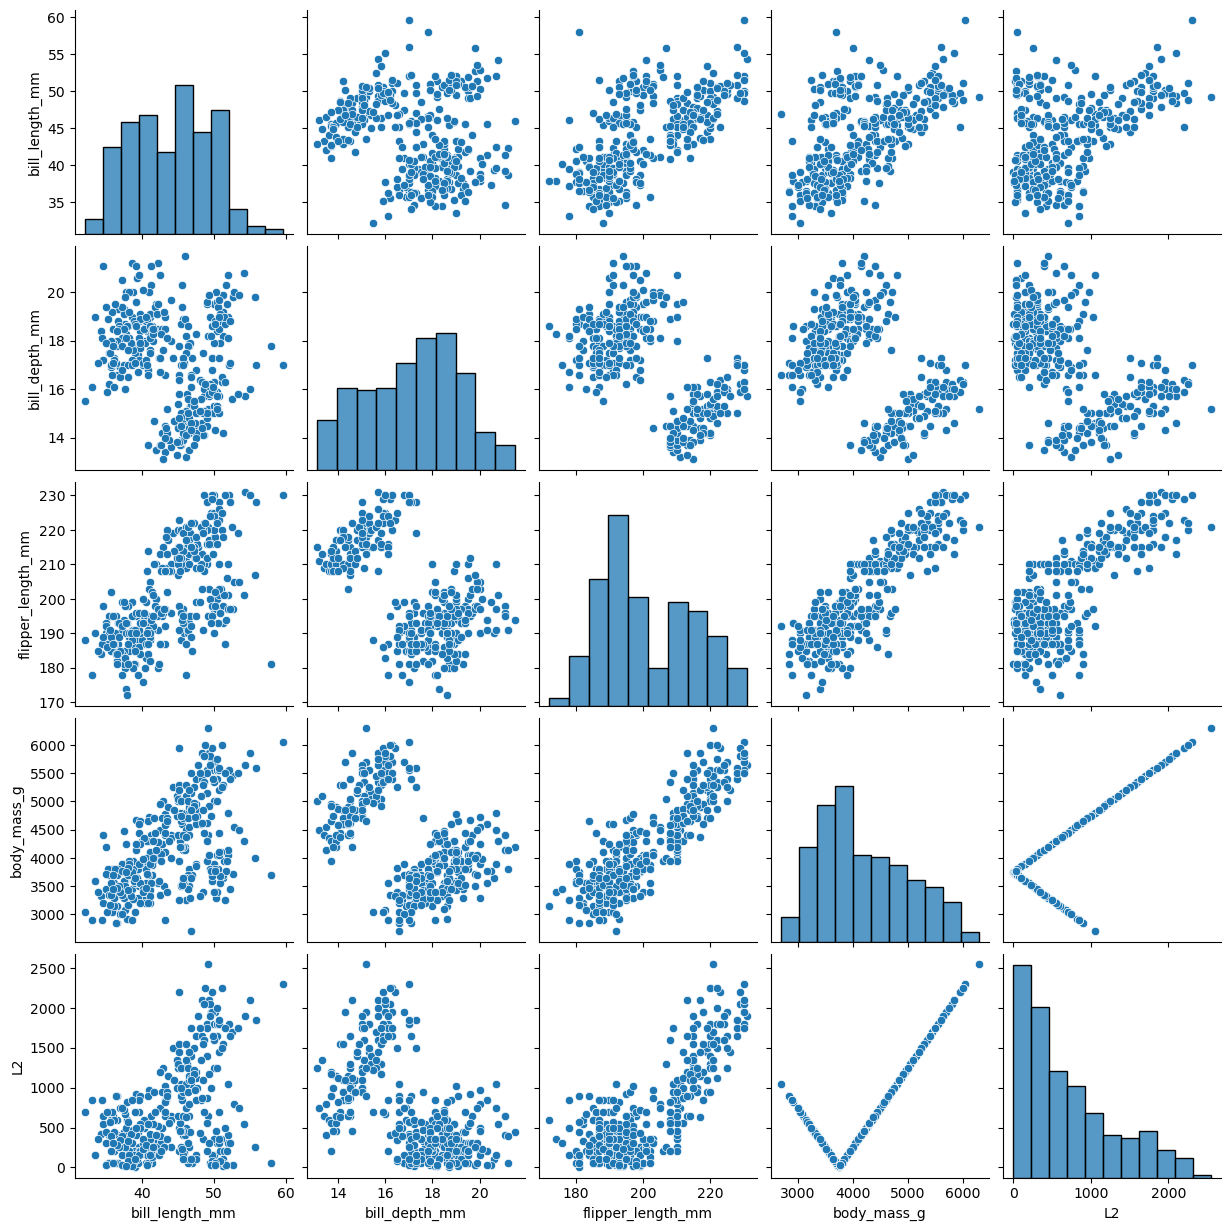

In [218]:
sns.pairplot(data=penguins);

Notice: the L2 distance and the body_mass_g columns are... basically the same thing.

**Discuss at your table**: What's happening here? Is this what we wanted? If not, why did this happen and what could we do about it?


Let's look at two penguins and see why this might have happened:

In [219]:
two_penguins = penguins.iloc[:2][numerical_features].to_numpy()
two_penguins

array([[  39.1,   18.7,  181. , 3750. ],
       [  39.5,   17.4,  186. , 3800. ]])

The difference betweeen these two 4D vectors?

In [221]:
d = two_penguins[0,:] - two_penguins[1,:]
d

array([ -0.4,   1.3,  -5. , -50. ])

#### Feature Extraction, Version 0.1
Last time, we extracted a 4D feature vector by just taking the numerical columns for each penguin.

This time, we'll add a step: convert each numerical columns to $z$-scores:

In [223]:
df = penguins.copy(deep=True)
for col in numerical_features:
    data = df[col]
    df[col] = (data - data.mean()) / data.std()

In [224]:
df

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen       -0.894695       0.779559          -1.424608   
1    Adelie  Torgersen       -0.821552       0.119404          -1.067867   
2    Adelie  Torgersen       -0.675264       0.424091          -0.425733   
4    Adelie  Torgersen       -1.333559       1.084246          -0.568429   
5    Adelie  Torgersen       -0.858123       1.744400          -0.782474   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe        0.586470      -1.759497           0.929884   
340  Gentoo     Biscoe        0.513326      -1.454811           1.001232   
341  Gentoo     Biscoe        1.171621      -0.743875           1.500670   
342  Gentoo     Biscoe        0.220750      -1.200905           0.787187   
343  Gentoo     Biscoe        1.080191      -0.540750           0.858536   

     body_mass_g     sex           L2  
0      -0.567621    Male     0.000000  
1      -0.505525  Female    50.267783  
2      -1.188572  Female   500.197891  
4      -0.940192  Female   300.250096  
5      -0.691811    Male   100.422358  
..           ...     ...          ...  
338     0.891616  Female  1175.501855  
340     0.798473  Female  1100.561061  
341     1.916186    Male  2000.454371  
342     1.233139  Female  1450.349413  
343     1.481520    Male  1650.347660  

[333 rows x 8 columns]

Now compute the L2 distance again:

In [225]:
penguin_0 = df.iloc[0][numerical_features]

df["L2_scaled"] = df[numerical_features].apply(lambda b: L(2, penguin_0, b[numerical_features]), axis=1)

Rank them:

In [226]:
df.sort_values("L2_scaled").head(20)

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen       -0.894695       0.779559          -1.424608   
145  Adelie      Dream       -0.912981       0.779559          -1.139215   
21   Adelie     Biscoe       -1.150699       0.779559          -1.495956   
105  Adelie     Biscoe       -0.784980       0.881121          -1.210563   
29   Adelie     Biscoe       -0.638692       0.881121          -1.495956   
26   Adelie     Biscoe       -0.620406       0.728778          -1.281911   
33   Adelie      Dream       -0.565548       0.881121          -1.210563   
6    Adelie  Torgersen       -0.931267       0.322529          -1.424608   
23   Adelie     Biscoe       -1.059269       0.474872          -1.139215   
31   Adelie      Dream       -1.242129       0.474872          -1.638652   
46   Adelie      Dream       -0.528976       0.931902          -1.353259   
77   Adelie  Torgersen       -1.242129       1.135027          -1.210563   
82   Adelie  Torgersen       -1.333559       0.830340          -0.996518   
147  Adelie      Dream       -1.351845       0.627216          -1.210563   
37   Adelie      Dream       -0.327830       0.677997          -1.495956   
89   Adelie      Dream       -0.931267       0.830340          -0.782474   
96   Adelie      Dream       -1.077555       0.728778          -0.782474   
88   Adelie      Dream       -1.040983       1.033465          -0.853822   
38   Adelie      Dream       -1.168985       1.084246          -1.424608   
71   Adelie  Torgersen       -0.784980       0.627216          -0.782474   

     body_mass_g     sex          L2  L2_scaled  
0      -0.567621    Male    0.000000   0.000000  
145    -0.691811    Male  100.080018   0.311780  
21     -0.753906    Male  150.009866   0.324547  
105    -0.816001    Male  200.023499   0.360362  
29     -0.319240    Male  200.007500   0.377672  
26     -0.816001    Male  200.015649   0.399836  
33     -0.381335    Male  150.040928   0.446285  
6      -0.722858  Female  125.003400   0.484059  
23     -0.319240    Male  200.042920   0.512894  
31     -0.381335    Male  150.043227   0.542275  
46     -0.971239    Male  325.007831   0.570051  
77     -0.381335    Male  150.043660   0.572350  
82     -0.505525  Female   50.415970   0.618301  
147    -0.909144  Female  275.027889   0.628210  
37     -0.816001  Female  200.026623   0.631217  
89     -0.753906  Female  150.269924   0.671532  
96     -0.629716  Female   50.813482   0.672464  
88     -0.319240    Male  200.162159   0.688010  
38     -1.126477  Female  450.002900   0.693101  
71     -0.381335    Male  150.271255   0.694467

And pairplot:

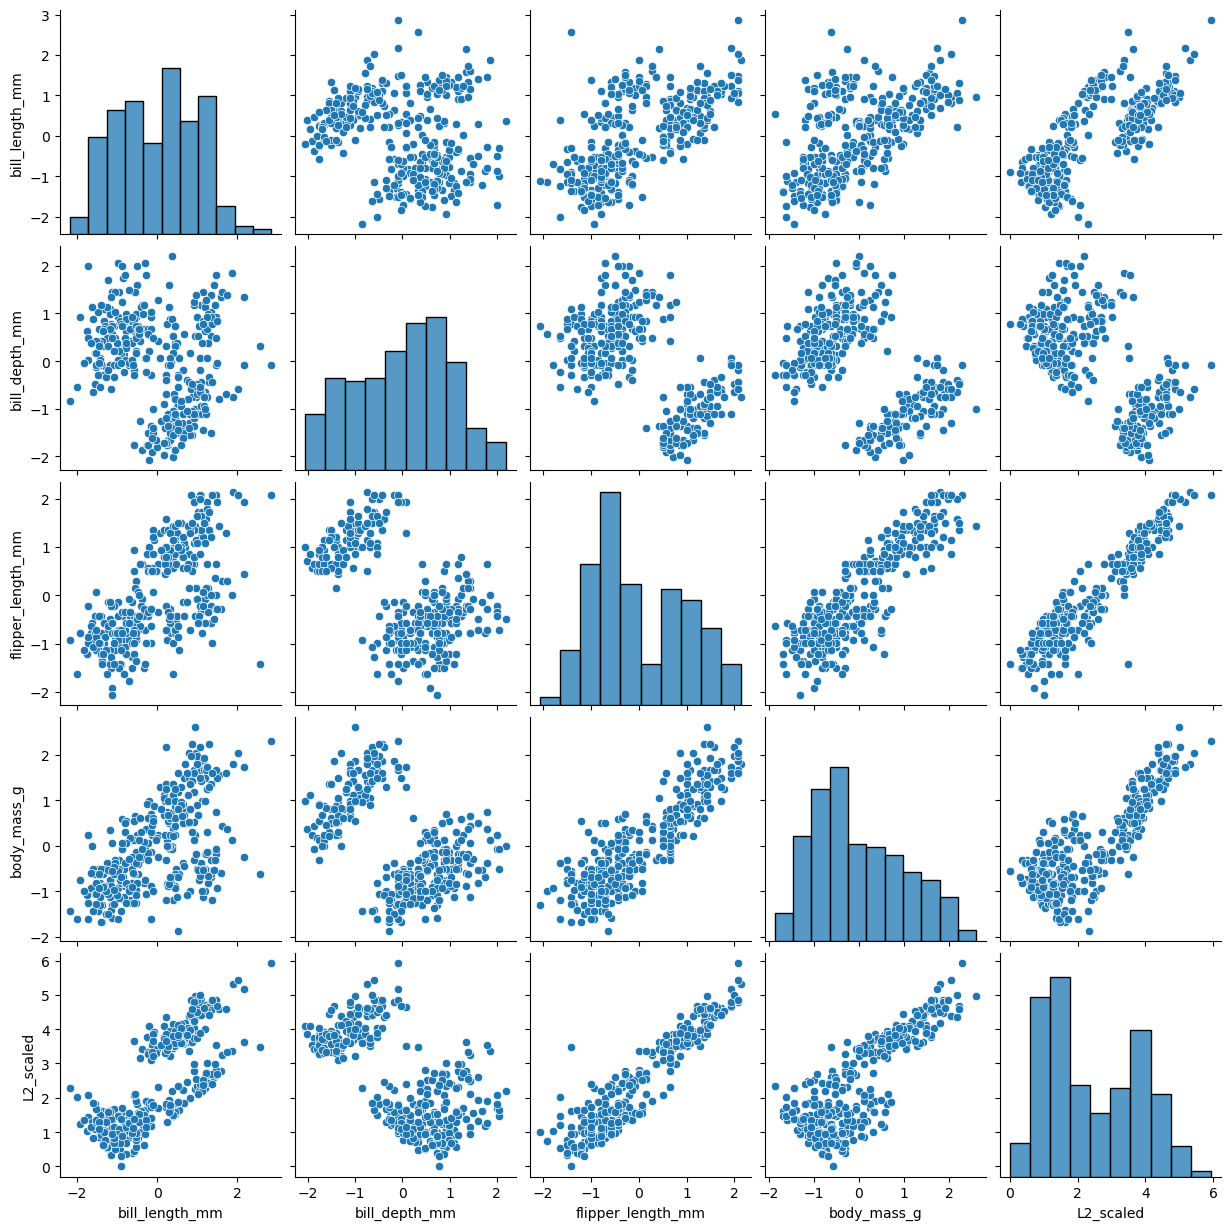

In [227]:
sns.pairplot(data=df.drop(columns="L2"))

## Clustering: Reminder

Setup, to match what we did last time - grab the species as a nominally-unknown property of interest:

In [228]:
y = df['species']

Recall we applied a **clustering algorithm** to decide which groups of points "belong together":

In [232]:
# ignore this code for now!
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

def cluster_demo_fit(X, scaling=True):
    if scaling:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X
    kmeans = KMeans(n_clusters=3, random_state=42)
    y_pred = kmeans.fit_predict(X_scaled)
    return y_pred

def cluster_demo_vis(df, x_col, y_col):
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Left Plot: True Species Labels
    sns.scatterplot( data=df, x=x_col, y=y_col, hue='species', palette='viridis', ax=axes[0], s=20, alpha=0.8)
    axes[0].set_title('Ground Truth (Actual Species)')
    axes[0].legend(title='Species')
    
    # Right Plot: Predicted Cluster Labels
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='cluster', palette='Set1', ax=axes[1], s=20, alpha=0.8, legend='full')
    axes[1].set_title(f'K-Means Clusters (K=3)')
    axes[1].legend(title='Cluster ID')
    
    plt.show()
    

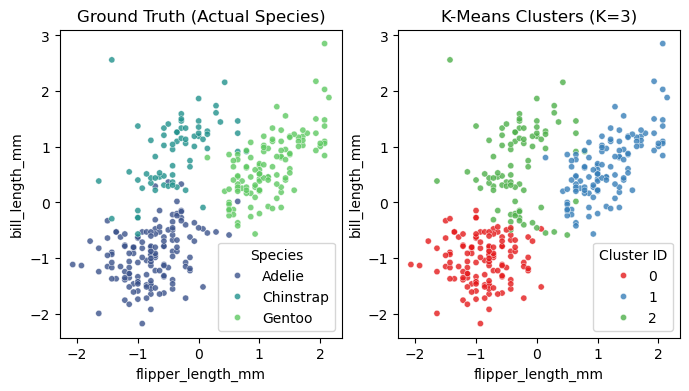

<Axes: xlabel='cluster', ylabel='species'>

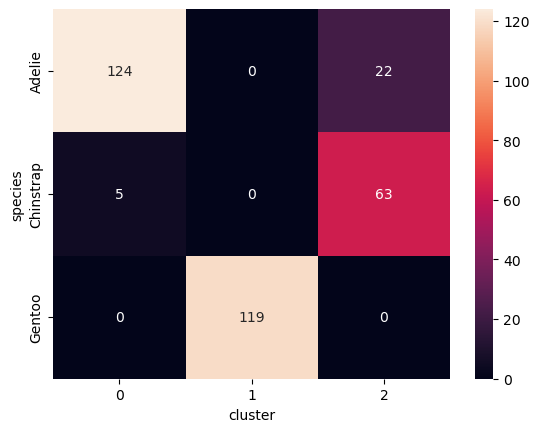

In [239]:
# cluster_demo_fit returns a column with the cluster number for each datapoint
X = penguins[numerical_features]
df['cluster'] = cluster_demo_fit(X, scaling=True)

# choose 2 axes to visualize along
x_col = 'flipper_length_mm'
y_col = 'bill_length_mm'

# scatterplot
cluster_demo_vis(df, x_col, y_col)

# Confusion matrix showing cluster assignment vs species
comparison_table = pd.crosstab(df['species'], df['cluster'])
sns.heatmap(comparison_table, annot=True, fmt='g')

## What about Categorical columns?


In [240]:
dfo = df.copy(deep=True)

In [242]:
categorical_features = ["island", "sex"]
dfo

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen       -0.894695       0.779559          -1.424608   
1    Adelie  Torgersen       -0.821552       0.119404          -1.067867   
2    Adelie  Torgersen       -0.675264       0.424091          -0.425733   
4    Adelie  Torgersen       -1.333559       1.084246          -0.568429   
5    Adelie  Torgersen       -0.858123       1.744400          -0.782474   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe        0.586470      -1.759497           0.929884   
340  Gentoo     Biscoe        0.513326      -1.454811           1.001232   
341  Gentoo     Biscoe        1.171621      -0.743875           1.500670   
342  Gentoo     Biscoe        0.220750      -1.200905           0.787187   
343  Gentoo     Biscoe        1.080191      -0.540750           0.858536   

     body_mass_g     sex           L2  L2_scaled  cluster  
0      -0.567621    Male     0.000000   0.000000        0  
1      -0.505525  Female    50.267783   0.756488        0  
2      -1.188572  Female   500.197891   1.248135        0  
4      -0.940192  Female   300.250096   1.075773        0  
5      -0.691811    Male   100.422358   1.166197        0  
..           ...     ...          ...        ...      ...  
338     0.891616  Female  1175.501855   4.039017        1  
340     0.798473  Female  1100.561061   3.837426        1  
341     1.916186    Male  2000.454371   4.617040        1  
342     1.233139  Female  1450.349413   3.647085        1  
343     1.481520    Male  1650.347660   3.880092        1  

[333 rows x 10 columns]

#### Hamming Distance

For vectors of categorical values, Hamming distance is the number of dimensions in which two vectors differ: 
$$d(a, b) = \sum_i \mathbb{1}(a_i \ne b_i)$$
where $\mathbb{1}(\cdot)$ is an indicator function that has value 1 if its argument is true and 0 otherwise.

**Exercise 2**: Compute the hamming distances between each pair of the following three penguins, based only on the island and sex columns:

In [243]:
dfo[categorical_features].loc[[1, 338, 33]]

island     sex
1    Torgersen  Female
338     Biscoe  Female
33       Dream    Male

* 1 vs 338: 1
* 1 vs 33: 2
* 338 vs 33: 2

### Numerical Encodings for Categorical Values


In [244]:
dfo["island"].value_counts()

island
Biscoe       163
Dream        123
Torgersen     47
Name: count, dtype: int64

#### Ordinal Encoding

In [245]:
dfo["island_ordinal"] = dfo["island"].map({"Biscoe": 1, "Dream": 2, "Torgersen": 3})
dfo[categorical_features + ["island_ordinal"]]

island     sex  island_ordinal
0    Torgersen    Male               3
1    Torgersen  Female               3
2    Torgersen  Female               3
4    Torgersen  Female               3
5    Torgersen    Male               3
..         ...     ...             ...
338     Biscoe  Female               1
340     Biscoe  Female               1
341     Biscoe    Male               1
342     Biscoe  Female               1
343     Biscoe    Male               1

[333 rows x 3 columns]

#### One-Hot Encoding

In [246]:
islands = list(dfo["island"].unique())
for island_name in islands:
    dfo[island_name] = (dfo["island"] == island_name).astype(int)

In [248]:
dfo[categorical_features + islands]

island     sex  Torgersen  Biscoe  Dream
0    Torgersen    Male          1       0      0
1    Torgersen  Female          1       0      0
2    Torgersen  Female          1       0      0
4    Torgersen  Female          1       0      0
5    Torgersen    Male          1       0      0
..         ...     ...        ...     ...    ...
338     Biscoe  Female          0       1      0
340     Biscoe  Female          0       1      0
341     Biscoe    Male          0       1      0
342     Biscoe  Female          0       1      0
343     Biscoe    Male          0       1      0

[333 rows x 5 columns]

**Exercise 3:** When would ordinal vs one-hot be advantageous?

# Clustering: How?

Let's look at the **k-means** clustering algorithm.

The basic idea is the following algorithm:

```
Inputs:
 k, an integer number of clusters, 
 X, an (n, d) dataset of feature vectors (one per row)

Let centroids be k randomly chosen datapoints (rows from X.)

Until convergence:
  1. For each point, assign it to the closest centroid

  2. For each centroid, update its location the mean of the points assigned to it

Outputs:
  centroids - a size (k, d) array of final locations of the k cluster centers
  assignments - a size (n,) int array saying which cluster center each point is closest to

In [253]:
# Visualization code - feel free to ignore
def visualize_clusters(X, centroids, labels, iteration, title):
    """
    Visualize the current state of clustering.
    
    Args:
        X: Data points (n_samples, 2)
        centroids: Current centroid positions (k, 2)
        labels: Cluster assignments for each point (n_samples,)
        iteration: Current iteration number
        title: Plot title
    """
    plt.figure(figsize=(8, 6))
    
    # Plot data points colored by cluster assignment
    if labels is not None:
        for k in range(len(centroids)):
            cluster_points = X[labels == k]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                       s=50, alpha=0.6, label=f'Cluster {k}')
    else:
        # No assignments yet, plot all points in gray
        plt.scatter(X[:, 0], X[:, 2], s=50, alpha=0.6, c='gray', label='Unassigned')
    
    # Plot centroids as large stars
    plt.scatter(centroids[:, 0], centroids[:, 1], 
               s=300, c='red', marker='*', 
               edgecolors='black', linewidths=2,
               label='Centroids', zorder=10)
    
    plt.xlabel('bill_length_mm')
    plt.ylabel('flipper_depth_mm')
    plt.title(f'{title} - Iteration {iteration}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gcf().savefig(f"kmeans_{iteration:02}.png")
    plt.show()


In [254]:
def kmeans(X, k, max_iterations=100, random_seed=42):
    n_samples, n_features = X.shape
    np.random.seed(random_seed)
    # Step 1: Initialize centroids randomly from data points
    random_indices = np.random.choice(n_samples, size=k, replace=False)
    centroids = X[random_indices].copy()
    
    visualize_clusters(X, centroids, None, 0, "Initial Random Centroids")

    labels = np.zeros(n_samples, dtype=int)
    # Iterate until convergence or max iterations
    for iteration in range(1, max_iterations + 1):
        
        ### Step 1: Assign each point to nearest centroid ###
        for i in range(n_samples):
            distances = [L(2, X[i], centroid) for centroid in centroids]
            labels[i] = np.argmin(distances)
    
        visualize_clusters(X, centroids, labels, iteration, "After Assignment")
        
        ### Step 2: Update centroid locations ###
        new_centroids = np.zeros_like(centroids)
        for cluster_id in range(k):
            cluster_points = X[labels == cluster_id]
            if len(cluster_points) > 0:
                new_centroids[cluster_id] = cluster_points.mean(axis=0)
        
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            print(f"Converged after {iteration} iterations")
            centroids
            break
        
        centroids = new_centroids
        
        visualize_clusters(X, centroids, labels, iteration, "After Centroid Update")
    
    
    return centroids, labels

In [255]:
X = dfo[numerical_features + islands].to_numpy()

In [256]:
dfo[numerical_features + islands]

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  Torgersen  \
0         -0.894695       0.779559          -1.424608    -0.567621          1   
1         -0.821552       0.119404          -1.067867    -0.505525          1   
2         -0.675264       0.424091          -0.425733    -1.188572          1   
4         -1.333559       1.084246          -0.568429    -0.940192          1   
5         -0.858123       1.744400          -0.782474    -0.691811          1   
..              ...            ...                ...          ...        ...   
338        0.586470      -1.759497           0.929884     0.891616          0   
340        0.513326      -1.454811           1.001232     0.798473          0   
341        1.171621      -0.743875           1.500670     1.916186          0   
342        0.220750      -1.200905           0.787187     1.233139          0   
343        1.080191      -0.540750           0.858536     1.481520          0   

     Biscoe  Dream  
0         0      0  
1         0      0  
2         0      0  
4         0      0  
5         0      0  
..      ...    ...  
338       1      0  
340       1      0  
341       1      0  
342       1      0  
343       1      0  

[333 rows x 7 columns]

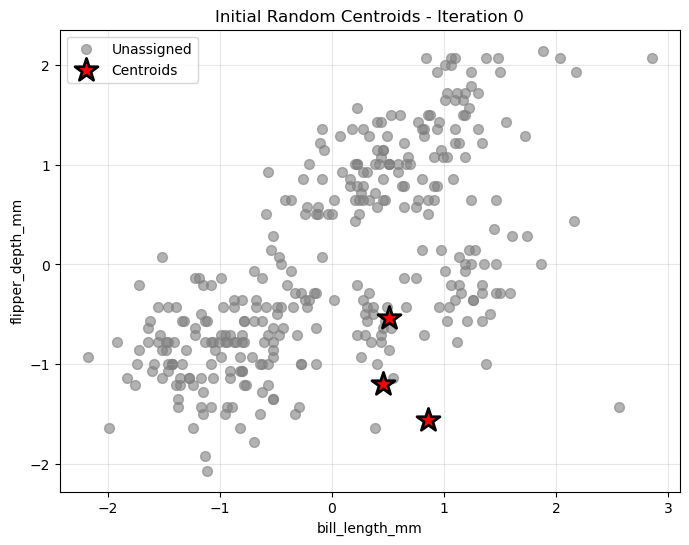

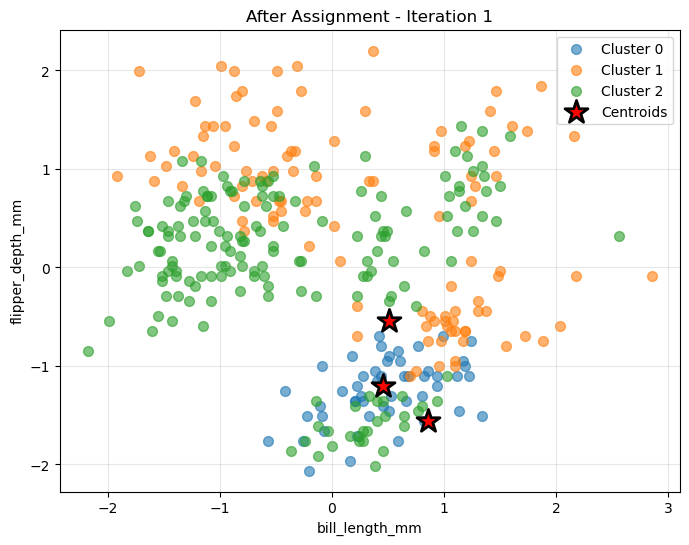

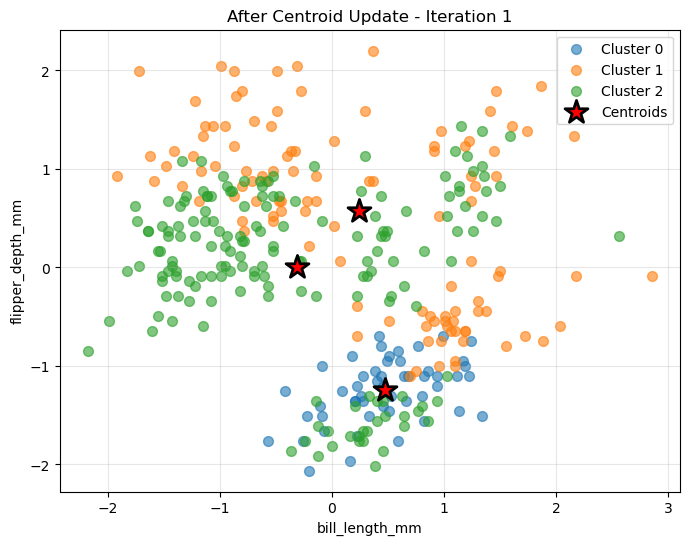

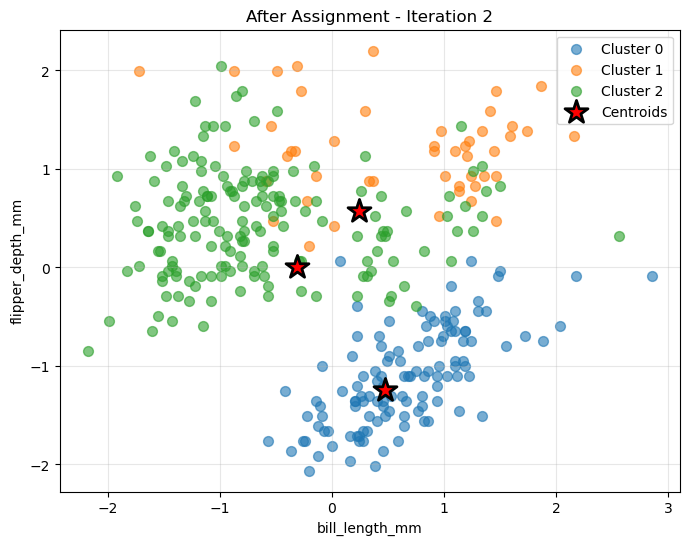

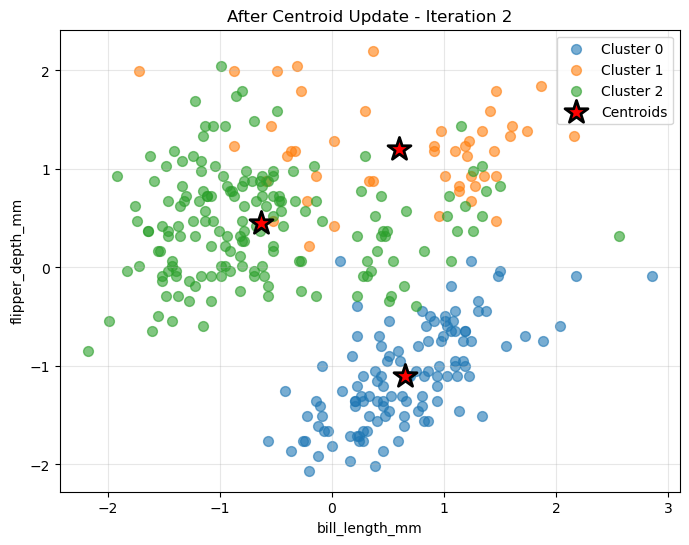

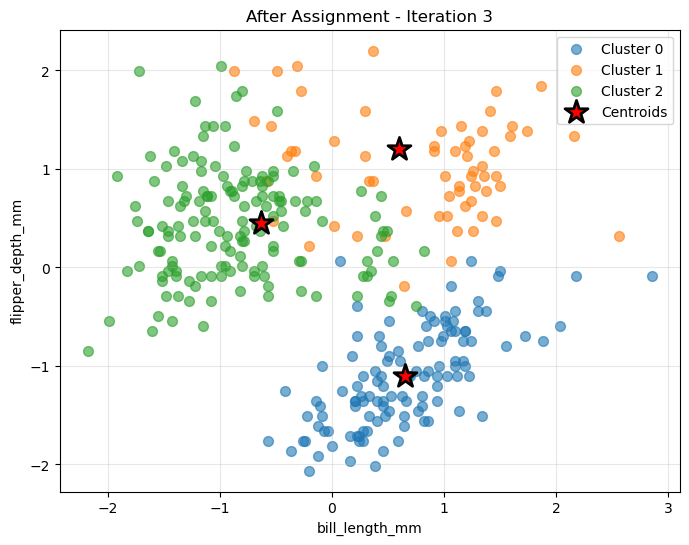

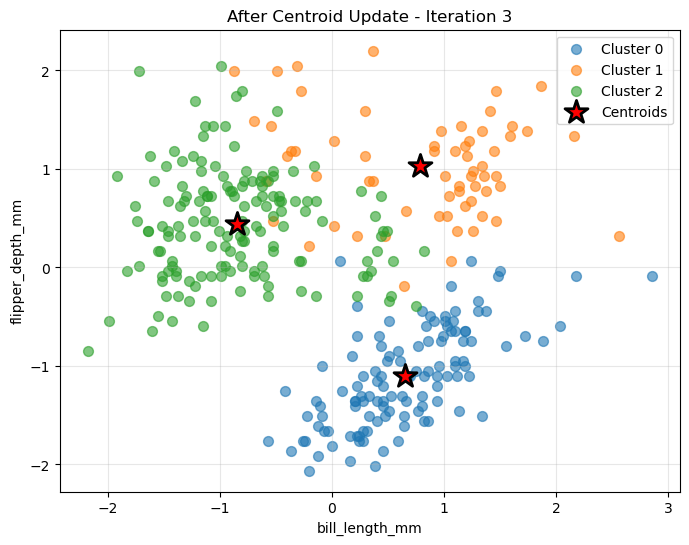

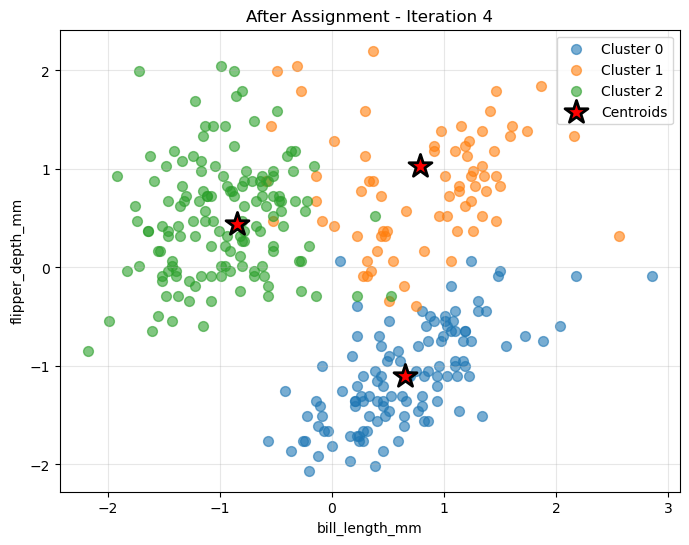

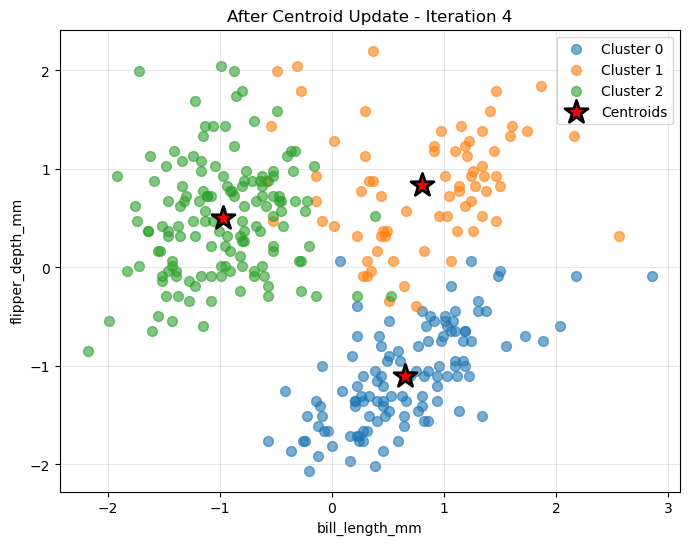

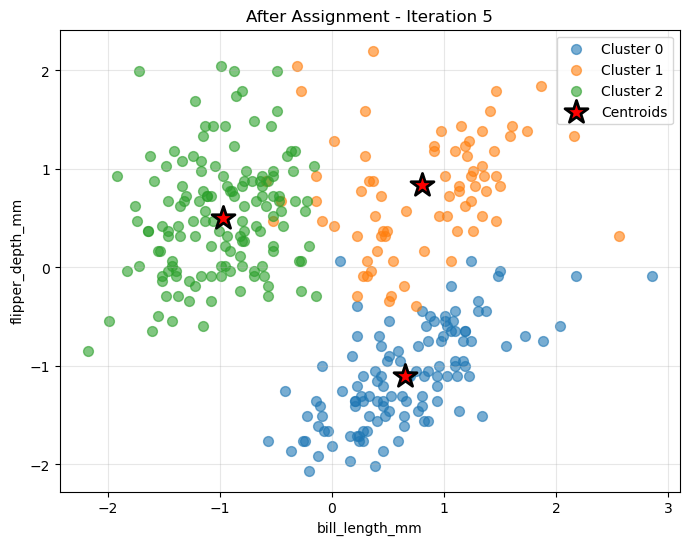

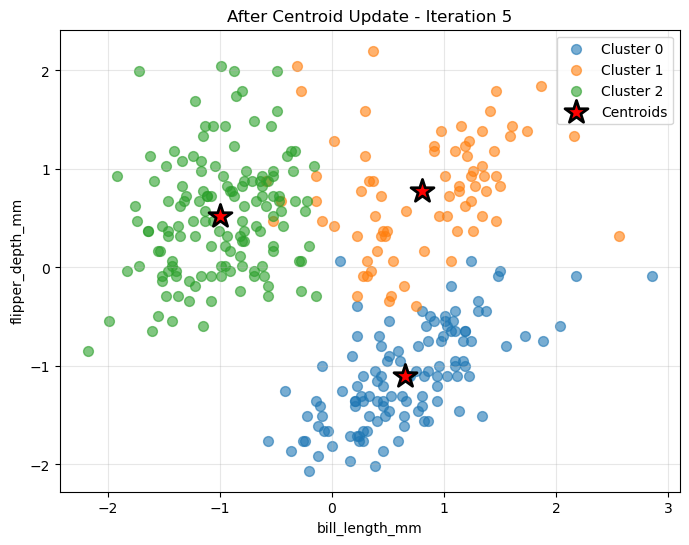

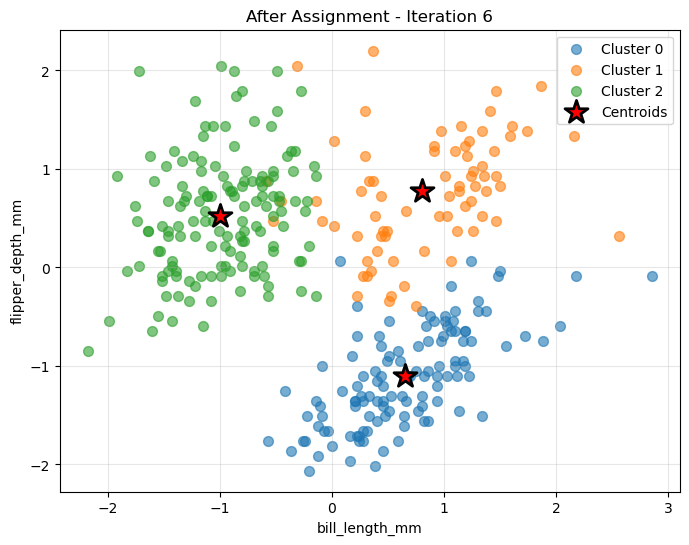

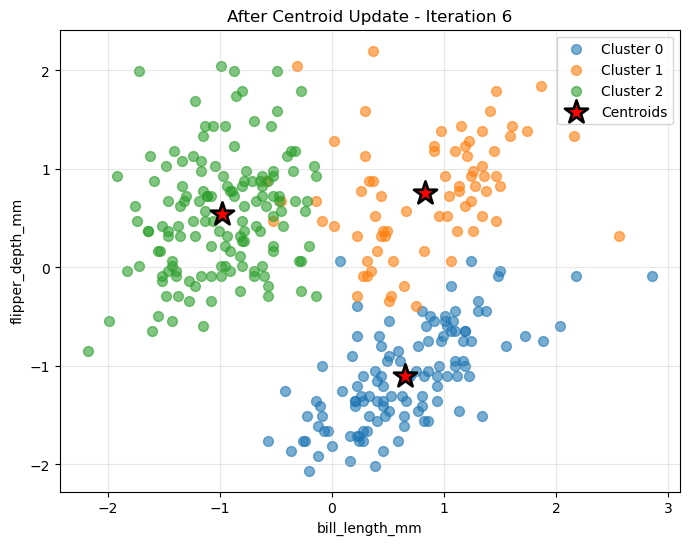

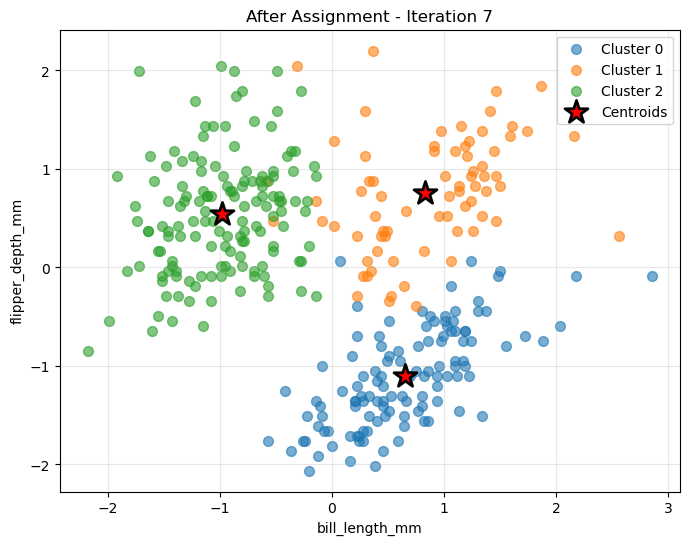

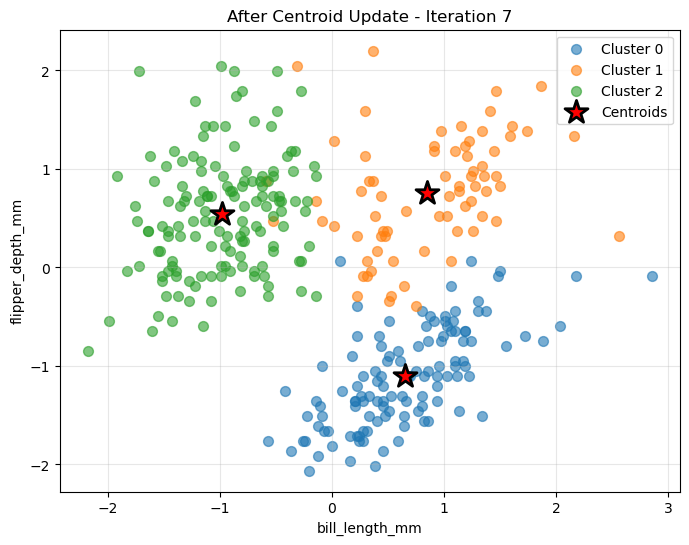

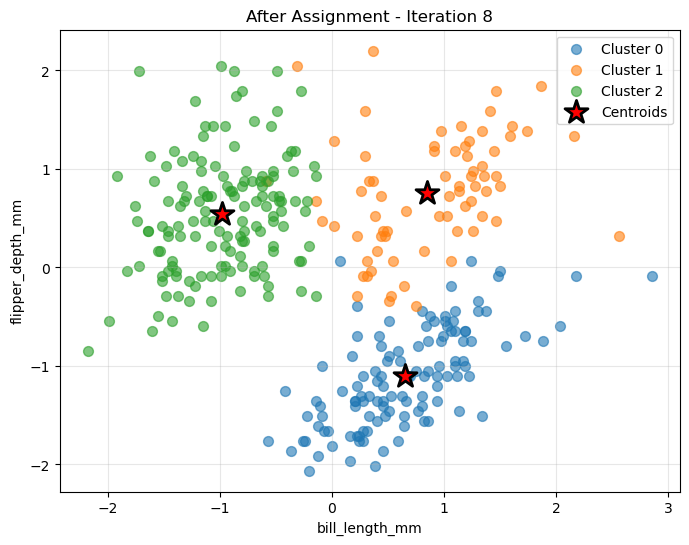

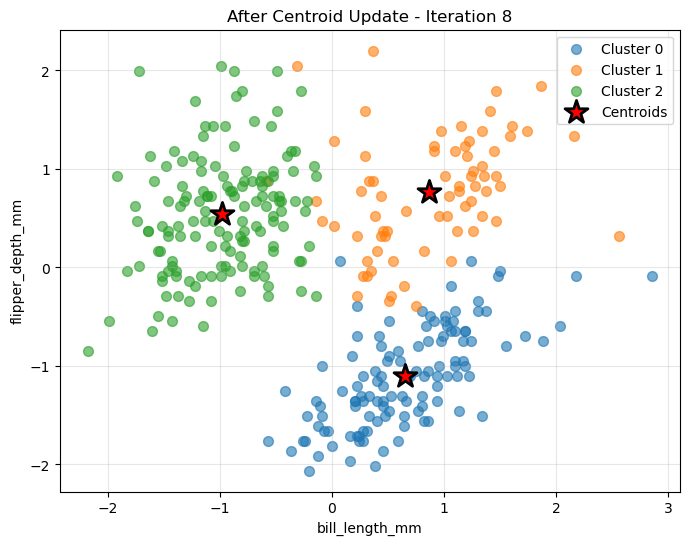

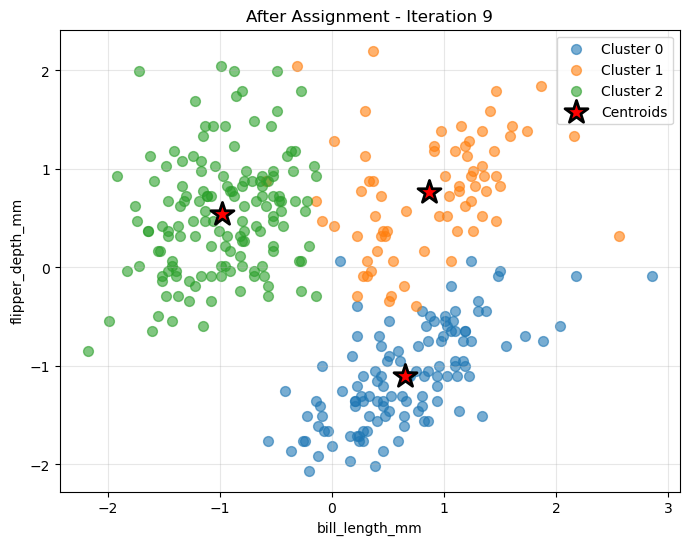

Converged after 9 iterations


(array([[ 0.65377423, -1.10104975,  1.16071629,  1.09955606,  0.        ,
          1.        ,  0.        ],
        [ 0.86951598,  0.76096305, -0.30413906, -0.47841345,  0.04225352,
          0.01408451,  0.94366197],
        [-0.97576761,  0.53843737, -0.81490466, -0.67748123,  0.30769231,
          0.3006993 ,  0.39160839]]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  

In [257]:
kmeans(X, 3, random_seed=12)